In [2]:
# ! pip install langflow
# For installing langflow it took 145 minutes, Use the existing environment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.8 MB/s eta 0:00:00-:--:--
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 28.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 35.7 MB/s eta 0:00:00
  Installing build dependencies ... -^C
anceled


In [ ]:
# ! pip install pandas pyodbc openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 25.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 34.6 MB/s eta 0:00:0000:0100:01


In [ ]:
# ! pip install vanna[chromadb,openai]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 17.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 34.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 35.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.6/615.6 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━

In [1]:
import sqlite3

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect("QRM.db")

# Create a cursor object to interact with the database
cursor = conn.cursor()

# # Create a table
# cursor.execute('''
#     CREATE TABLE IF NOT EXISTS users (
#         id INTEGER PRIMARY KEY AUTOINCREMENT,
#         name TEXT NOT NULL,
#         age INTEGER NOT NULL
#     )
# ''')

# # Insert data into the table
# cursor.execute("INSERT INTO users (name, age) VALUES (?, ?)", ("Alice", 25))
# cursor.execute("INSERT INTO users (name, age) VALUES (?, ?)", ("Bob", 30))

# # Commit the changes
# conn.commit()

query = """SELECT 
    "Actual" AS "Power Utility Actual"
FROM 
    utility
WHERE 
    "Product" = 'Towel' AND
    "Utility" = 'Power' AND
    "Particulars" = 'Processing' AND
    "Plant" = 'Anjar' AND
    "Month-Year" IN ('Oct-24', 'Nov-24', 'Dec-24');"""
# Run a query
cursor.execute(query)

# Fetch all rows
rows = cursor.fetchall()

# Print the results
for row in rows:
    print(row)

# Close the connection
conn.close()


(0.4,)
(0.49,)
(0.46,)


In [2]:
from vanna.openai import OpenAI_Chat
from vanna.chromadb import ChromaDB_VectorStore


c:\Users\0200704\.conda\envs\tf-gpu\Lib\site-packages\onnxruntime\capi\onnxruntime_validation.py:26: UserWarning: Unsupported Windows version (2022server). ONNX Runtime supports Windows 10 and above, only.
  warnings.warn(


In [ ]:
openai_api = ' '

In [4]:
class MyVanna(ChromaDB_VectorStore, OpenAI_Chat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        OpenAI_Chat.__init__(self, config=config)

vn = MyVanna(config={'api_key': openai_api, 'model': 'gpt-4o'})

In [5]:
import pandas as pd
import sqlite3

# Read the CSV file and parse dates
csv_file = 'QRM_6m.csv'
df = pd.read_csv(csv_file, parse_dates=True)

# Infer data types
data_types = df.dtypes

# Create SQLite database and table
conn = sqlite3.connect('QRM.db')
cursor = conn.cursor()

# Define a function to map pandas data types to SQLite data types
def map_dtype(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INTEGER'
    elif pd.api.types.is_float_dtype(dtype):
        return 'REAL'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'TEXT'  # SQLite does not have a dedicated date type, use TEXT
    else:
        return 'TEXT'

# Create table schema with quoted column names
table_name = 'utility'
columns = ', '.join([f'"{col}" {map_dtype(dtype)}' for col, dtype in data_types.items()])
create_table_query = f'CREATE TABLE IF NOT EXISTS {table_name} ({columns})'
cursor.execute(create_table_query)

# Insert data into the table
df.to_sql(table_name, conn, if_exists='replace', index=False)

# Commit and close the connection
conn.commit()
conn.close()

print("Data has been successfully imported into the SQLite database")

Data has been successfully imported into the SQLite database


In [6]:
vn.connect_to_sqlite('QRM.db')

In [6]:
# [
#   {
#     "role": "system",
#     "content": "You are a SQLite expert. Please help to generate a SQL query to answer the question. \
#     Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \
#     ===Response Guidelines\n \
#     1. If the provided context is sufficient, please generate a valid SQL query without any explanations for the question.\n \
#     2. If the provided context is almost sufficient but requires knowledge of a specific string in a particular column, please generate an intermediate SQL query to find the distinct strings in that column. \
#     Prepend the query with a comment saying intermediate_sql\n \
#     3. If the provided context is insufficient, please explain why it can't be generated.\n \
#     4. Please use the most relevant table(s).\n \
#     5. If the question has been asked and answered before, please repeat the answer exactly as it was given before.\n \
#     6. Ensure that the output SQL is SQLite-compliant and executable, and free of syntax errors.\n"
#   },
#   {
#     "role": "user",
#     "content": "What is the total sales for the year 2019?"
#   }
# ]

### Training model

In [7]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

for ddl in df_ddl['sql'].to_list():
  vn.train(ddl=ddl)

Adding ddl: CREATE TABLE "utility" (
"Month-Year" TEXT,
  "Product" TEXT,
  "Utility" TEXT,
  "Particulars" TEXT,
  "UOM" TEXT,
  "Bplan" REAL,
  "Target" REAL,
  "Actual" REAL,
  "Bplan  Var %" TEXT,
  "Target  Var %" TEXT,
  "Plant" TEXT
)


Add of existing embedding ID: 7727706b-1a0c-5063-a328-efcbec3b2065-ddl
Add of existing embedding ID: 7727706b-1a0c-5063-a328-efcbec3b2065-ddl
Insert of existing embedding ID: 7727706b-1a0c-5063-a328-efcbec3b2065-ddl
Add of existing embedding ID: 7727706b-1a0c-5063-a328-efcbec3b2065-ddl
Insert of existing embedding ID: 7727706b-1a0c-5063-a328-efcbec3b2065-ddl
Add of existing embedding ID: 7727706b-1a0c-5063-a328-efcbec3b2065-ddl


In [8]:
# Sometimes you may want to add documentation about your business terminology or definitions.
vn.train(documentation="The 'Utility' table contains the Utility for QRM data.")


Add of existing embedding ID: 223e3f8b-997e-55a7-b1e3-d7e1de38a0d2-doc
Insert of existing embedding ID: 223e3f8b-997e-55a7-b1e3-d7e1de38a0d2-doc
Add of existing embedding ID: 223e3f8b-997e-55a7-b1e3-d7e1de38a0d2-doc


Adding documentation....


'223e3f8b-997e-55a7-b1e3-d7e1de38a0d2-doc'

In [9]:
# At any time you can inspect what training data the package is able to reference
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,9f374063-8780-5df7-a7dc-a256bd761b2a-sql,How many months of data we have in Utility?,"SELECT COUNT(DISTINCT ""Month-Year"") AS number_...",sql
1,832a69b8-3cbf-5068-8ec4-dc1f2fd7c19f-sql,How many months of data we have in Utility?,"SELECT COUNT(DISTINCT strftime('%Y-%m', date_c...",sql
0,7727706b-1a0c-5063-a328-efcbec3b2065-ddl,None,"CREATE TABLE ""utility"" (\n""Month-Year"" TEXT,\n...",ddl
0,223e3f8b-997e-55a7-b1e3-d7e1de38a0d2-doc,None,The 'Utility' table contains the Utility for Q...,documentation


In [14]:
# # You can remove training data if there's obsolete/incorrect information. 
# vn.remove_training_data(id='1-ddl')


Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


SQL Prompt: [{'role': 'system', 'content': 'You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE "utility" (\n"Month-Year" TEXT,\n  "Product" TEXT,\n  "Utility" TEXT,\n  "Particulars" TEXT,\n  "UOM" TEXT,\n  "Bplan" REAL,\n  "Target" REAL,\n  "Actual" REAL,\n  "Bplan  Var %" TEXT,\n  "Target  Var %" TEXT,\n  "Plant" TEXT\n)\n\n\n===Additional Context \n\nThe \'Utility\' table contains the Utility for QRM data.\n\n===Response Guidelines \n1. If the provided context is sufficient, please generate a valid SQL query without any explanations for the question. \n2. If the provided context is almost sufficient but requires knowledge of a specific string in a particular column, please generate an intermediate SQL query to find the distinct strings in that column. Prepend the query with a comment saying intermediate_sql \n

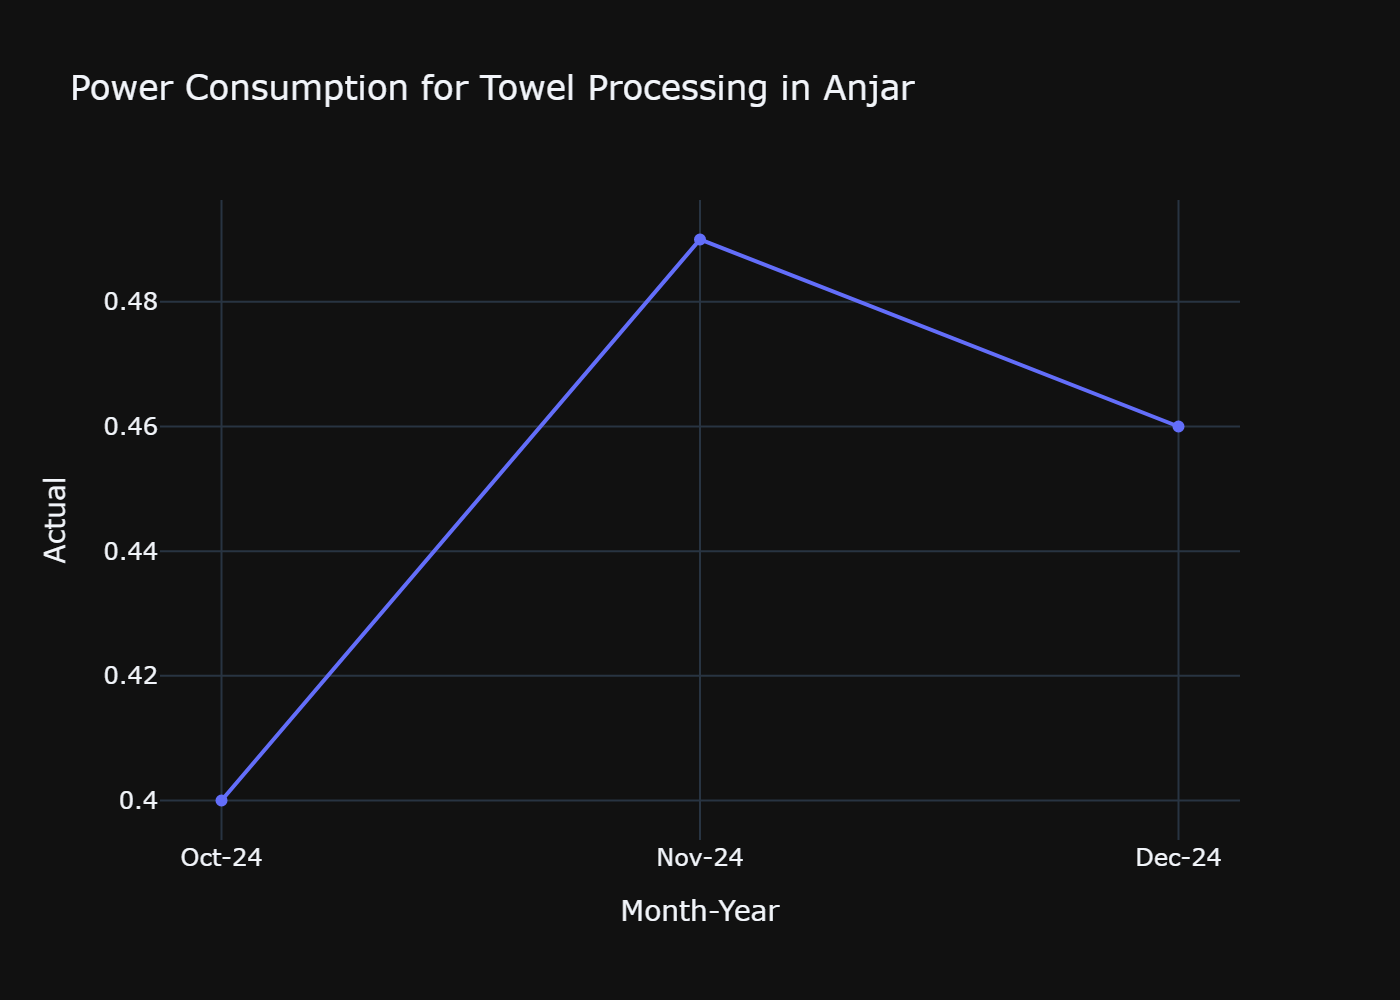

('SELECT \n    "Month-Year", \n    "Actual" \nFROM \n    utility \nWHERE \n    "Product" = \'Towel\' AND \n    "Utility" = \'Power\' AND \n    "Particulars" = \'Processing\' AND \n    "Plant" = \'Anjar\' AND \n    "Month-Year" IN (\'Oct-24\', \'Nov-24\', \'Dec-24\');',
   Month-Year  Actual
 0     Oct-24    0.40
 1     Nov-24    0.49
 2     Dec-24    0.46,
 Figure({
     'data': [{'hovertemplate': 'Month-Year=%{x}<br>Actual=%{y}<extra></extra>',
               'legendgroup': '',
               'line': {'color': '#636efa', 'dash': 'solid'},
               'marker': {'symbol': 'circle'},
               'mode': 'lines+markers',
               'name': '',
               'orientation': 'v',
               'showlegend': False,
               'type': 'scatter',
               'x': array(['Oct-24', 'Nov-24', 'Dec-24'], dtype=object),
               'xaxis': 'x',
               'y': array([0.4 , 0.49, 0.46]),
               'yaxis': 'y'}],
     'layout': {'legend': {'tracegroupgap': 0},
       

In [11]:
# query_res = vn.ask('How many months of data we have in Utility?')
query_res = vn.ask('analysis of power consumption for towel processing in Anjar for the quarter ending Dec-24')
query_res

In [11]:
from vanna.flask import VannaFlaskApp
app = VannaFlaskApp(vn)
app.run()

Your app is running at:
http://localhost:8084
 * Serving Flask app 'vanna.flask'
 * Debug mode: on
 * Debug mode: on
